In [1]:
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
# from IPython.display import display, HTML

from pykat import finesse
from pykat.commands import *
pykat.init_pykat_plotting(dpi=90)

from pprint import pprint as pprint

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# base model that holds the components, run detection models on top of this
basekat = finesse.kat()
#basekat.verbose = False

basecode = """
# no spaces in model, except inside cavity

l laser 1 0 0 nbs1 # power = 1W
bs BS 0.5 0.5 0 45 nbs1 nbs2 nbs3 nbs4 # phi = 0

s sdbs1 0 nbs4 ndbs1 # zero length space
dbs isol ndbs1 ndbs2 ndbs3 ndbs4  # dbs doesn't req R T phi alpha
s sdbs2 0 ndbs2 nc0 # zero length space

m m1 0.9 0.1 0 nc0 nc1 # R = 0.9, T = 0.1, phi = 0
s sc1 0.5 nc1 nc2 # total cavity L = 1m
nle nle1 0.05 0 nc2 nc3 # r = 0.05, sqz angle = 0
s sc2 0.5 nc3 nc4 # total cavity L = 1m
m m2 1 0 0 nc4 nc5 # R = 1, T = 0, phi = 0

# homodyne detector and quantum noise
qhd qn 180 nbs2 nbs3
fsig noise 1 # noise at 1 Hz

# by default noise enters through every open port, lossy optic, or squeezer
# -- Quantum noise inputs --
#   |- %10-.10s - laser Node LASER NOISE
#   |- %10-.10s - m2 Node OPEN PORT
#   |- %10-.10s - BS Node OPEN PORT
#   |- %10-.10s - BS Node OPEN PORT
#   |- %10-.10s - isol Node OPEN PORT
#   |- %10-.10s - isol Node OPEN PORT
# can instead specify exactly where through "vacuum" command
vacuum isol laser
# printnoises

"""

basekat.parse(basecode)

Parsing `nle nle1 0.05 0 nc2 nc3` into pykat object not implemented yet, added as extra line.
Parsing `vacuum isol laser` into pykat object not implemented yet, added as extra line.


In [3]:
pprint((basekat.components, basekat.detectors, basekat.commands))

({'BS': <pykat.components.beamSplitter_2 (BS) at 0x7f5adfdc0208>,
  'isol': <pykat.components.dbs_4 (isol) at 0x7f5adfd5c080>,
  'laser': <pykat.components.laser_1 (laser) at 0x7f5adfdc0550>,
  'm1': <pykat.components.mirror_6 (m1) at 0x7f5adfd5c860>,
  'm2': <pykat.components.mirror_9 (m2) at 0x7f5adfd627f0>,
  'sc1': <pykat.components.space_7 (sc1) at 0x7f5adfd62080>,
  'sc2': <pykat.components.space_8 (sc2) at 0x7f5adfd62390>,
  'sdbs1': <pykat.components.space_3 (sdbs1) at 0x7f5adfd4d278>,
  'sdbs2': <pykat.components.space_5 (sdbs2) at 0x7f5adfd4def0>},
 {'qn': <pykat.detectors.pykat.detectors.qhd_1 object at 0x7f5adfd67160>},
 {})


In [4]:
kat1 = deepcopy(basekat)

kat1code = """
xaxis nle1 r lin -1 1 10000 # to spot threshold
#yaxis abs:deg
"""

kat1.parse(kat1code)

In [5]:
# pprint((kat1.components, kat1.detectors, kat1.commands))
out1 = kat1.run()
print(out1.stdout)

--------------------------------------------------------------
Running kat - Started at 2020-08-20 14:49:37.260823
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.174752 seconds

------------------------------------------------------------------------
                     FINESSE 2.3.1            (build 2.3.1.11-ga3cc55b2)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        06.07.2020         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /tmp/tmpu5ng8_6r.kat,
  ~~ \)-'   '        Output file /tmp/tmpu5ng8_6r.out,
     / |             Gnuplot file /tmp/tmpu5ng8_6r.gnu 
    '  '                                        Thu Aug 20 14:49:37 2020
------------------------------------------------------------------------
 
 computation time:  0.113911s



100% | ETA:  0:00:00 | Calculating                                             

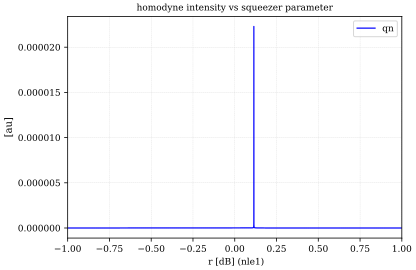

In [6]:
out1.plot(detectors=['qn'], title="homodyne intensity vs squeezer parameter")

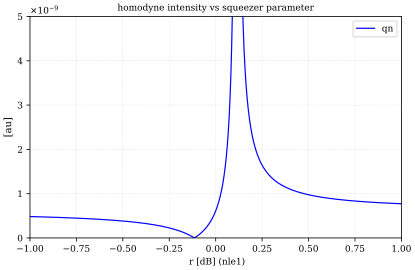

In [7]:
# detectors=['qn']
out1.plot(filename='pykat_qhd_vs_r.pdf',
          title="homodyne intensity vs squeezer parameter",
          ylim=(0, 0.5*1e-8))

In [8]:
# checking limits against HomI(0)
homI_zero = out1.y[np.searchsorted(out1.x, 0)][0]
print(out1.y[0], homI_zero, out1.y[-1])

[4.83654039e-10] 6.11058157799027e-10 [7.72023062e-10]


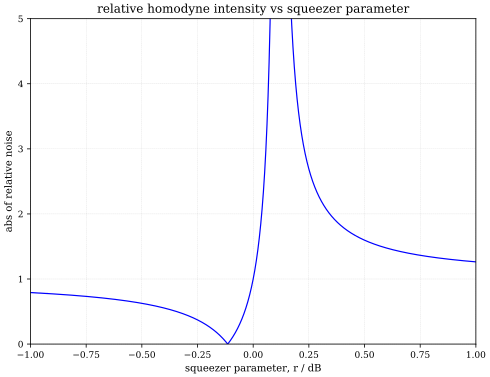

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(out1.x, out1.y/homI_zero)
ax.set_ylim(0, 5)
ax.set(title="relative homodyne intensity vs squeezer parameter",
       xlabel="squeezer parameter, r / dB",
       ylabel="abs of relative noise")
fig.savefig("pykat_relative_qhd_vs_r.pdf")
plt.show()

In [33]:
# finding threshold
print(out1.x[out1.y.argmin()], out1.x[out1.y.argmax()])
rThresh = 0.1144

-0.1144 0.1144


In [10]:
kat3 = deepcopy(basekat)

kat3code = """
variable sqzr 0
put nle1 r $sqzr

xaxis laser f lin 0 5G 10000
#yaxis abs:deg
"""

kat3.parse(kat3code)

out3 = kat3.run()

out3.plot()

Parsing `variable sqzr 0` into pykat object not implemented yet, added as extra line.

put command `put nle1 r $sqzr` refers to non-existing
component


Parsing `put nle1 r $sqzr` into pykat object not implemented
yet, added as extra line.

--------------------------------------------------------------
Running kat - Started at 2020-08-20 14:49:39.500395

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
 
Error:  Line `put nle1 r $sqzr ':
function_name/set/axis name '$sqzr' not found. 
--------------------------------------------------------------


Finished in 0.0146685 seconds


SystemExit: 1

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [25]:
# a hack: want to set r param but isn't co-operating, so hard code everything again
hackbase = finesse.kat()
hackbase.verbose = False

hackbasecode = """
l laser 1 0 0 nbs1 # power = 1W
bs BS 0.5 0.5 0 45 nbs1 nbs2 nbs3 nbs4 # phi = 0

s sdbs1 0 nbs4 ndbs1 # zero length space
dbs isol ndbs1 ndbs2 ndbs3 ndbs4  # dbs doesn't req R T phi alpha
s sdbs2 0 ndbs2 nc0 # zero length space

m m1 0.9 0.1 0 nc0 nc1 # R = 0.9, T = 0.1, phi = 0
s sc1 0.5 nc1 nc2 # total cavity L = 1m
s sc2 0.5 nc3 nc4 # total cavity L = 1m
m m2 1 0 0 nc4 nc5 # R = 1, T = 0, phi = 0

qhd qn 180 nbs2 nbs3
fsig noise 1 # noise at 1 Hz

vacuum isol laser
"""

hackbase.parse(hackbasecode)

In [26]:
def hacksqz(sqz_r):
    hackkat = deepcopy(hackbase)

    hackcode = """
    nle nle1 {0} 0 nc2 nc3 # r = {0}, sqz angle = 0
    
    xaxis laser f lin 0 5G 10000
    """.format(sqz_r)

    hackkat.parse(hackcode)

    return hackkat.run()

In [27]:
zeroreference = hacksqz(0).y

r1, r2, r3, r4 = 0.05





In [ ]:
# kat2 = deepcopy(kat1)

# kat2code = """
# xaxis nle1 phi lin -180 180 10000 # to spot threshold
# """

# kat2.parse(kat2code)

# out2 = kat2.run()
# out2.plot()

In [ ]:
# # Vaishali's test code to check nle installed
# testkat = finesse.kat()
# testcode = """
# l l1 1 0 0 n1
# s s0 1 ni na
# nle nle1 -10 0 na nb
# s s1 1 nb n4
# bs bs1 0.5 0.5 0 0 n1 n2 n3 n4
# qhd qn 180 n2 n3
# fsig noise 1
# noxaxis
# printnoises
# """
# testkat.parse(testcode)

# out = testkat.run()
# print(out.stdout)